# Preisverfall von Mobiltelefonen

## setup

In [2]:
import requests
import pandas as pd
import time
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

plt.xkcd()

## data collection

In [3]:
product_list = [
    #['Samsung Galaxy S Series', 'Galaxy S1', 535151],
    #['Samsung Galaxy S Series', 'Galaxy S2', 615532],
    #['Samsung Galaxy S Series', 'Galaxy S3', 772300],
    #['Samsung Galaxy S Series', 'Galaxy S4', 917778],
    #['Samsung Galaxy S Series', 'Galaxy S5', 1075683],
    ['Samsung Galaxy S Series', 'Galaxy S6', 1237277],
    ['Samsung Galaxy S Series', 'Galaxy S7', 1397048],
    ['Samsung Galaxy S Series', 'Galaxy S8', 1601178],
    ['Samsung Galaxy S Series', 'Galaxy S9', 1776751],
    ['Samsung Galaxy S Series', 'Galaxy S10', 1992667],
    
    #['Apple', 'iPhone 4s 16GB', 687504],
    #['Apple', 'iPhone 5 16GB', 837396],
    #['Apple', 'iPhone 5s 16GB', 999650],
    #['Apple', 'iPhone 6 16GB', 1163683],
    #['Apple', 'iPhone 6s 16GB', 1322858],
    #['Apple', 'iPhone 7 32GB', 1504539],
    #['Apple', 'iPhone 8 64GB', 1688628],
    #['Apple', 'iPhone XR 64GB', 1887154],
   
    #['Huawei P Series', 'P8 schwarz', 1257393],
    #['Huawei P Series', 'P9 32GB grau', 1422604],
    #['Huawei P Series', 'P10 Dual-SIM schwarz', 1592427],
    #['Huawei P Series', 'P20 Pro Dual-SIM schwarz', 1793668],
    #['Huawei P Series', 'P30 Pro Dual-SIM schwarz', 2018773]
]

In [4]:
def scrapePrices(product_list):
    df_raw = pd.DataFrame()

    for product in product_list:
        url = 'https://geizhals.de/?phist='+str(product[2])+'&age=9999'
        print(url)
        r = requests.get(url).text

        split_string = '_gh.plot('+str(product[2])
        prices = r.split(split_string)[1].split(', ')[1].split(']],')[0]
        prices = prices.strip().replace('null','0')
        
        prices = ast.literal_eval(prices)

        df = pd.DataFrame.from_dict(prices)
        df.columns = ['timestamp', 'price','unknown']
        
        df['manufacturer'] = product[0]
        df['product'] = product[1]
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df['market_day'] = df.index   

        df = df[df['market_day'] < 1095]   
        
        df['price_avg_week'] = df['price'].rolling(7).mean()
        df['price_perc'] = df['price'] / df['price'][1:3].mean()
        df['price_perc_week'] = df['price_perc'].rolling(7).mean()
        
        df_raw = df_raw.append(df, ignore_index=True)
        time.sleep(random.uniform(0, 1)*25)
    return df_raw

In [5]:
df_raw = scrapePrices(product_list)

https://geizhals.de/?phist=1237277&age=9999
https://geizhals.de/?phist=1397048&age=9999
https://geizhals.de/?phist=1601178&age=9999
https://geizhals.de/?phist=1776751&age=9999
https://geizhals.de/?phist=1992667&age=9999


In [6]:
df_raw.to_csv('../data/raw/2019_04_13_prices.csv', sep='\t', encoding='utf-8')

## data analysis

In [7]:
df_analysis = pd.read_csv('../data/raw/2019_04_13_prices.csv', sep='\t', encoding='utf-8')
df_analysis['timestamp'] = pd.to_datetime(df_analysis['timestamp'])

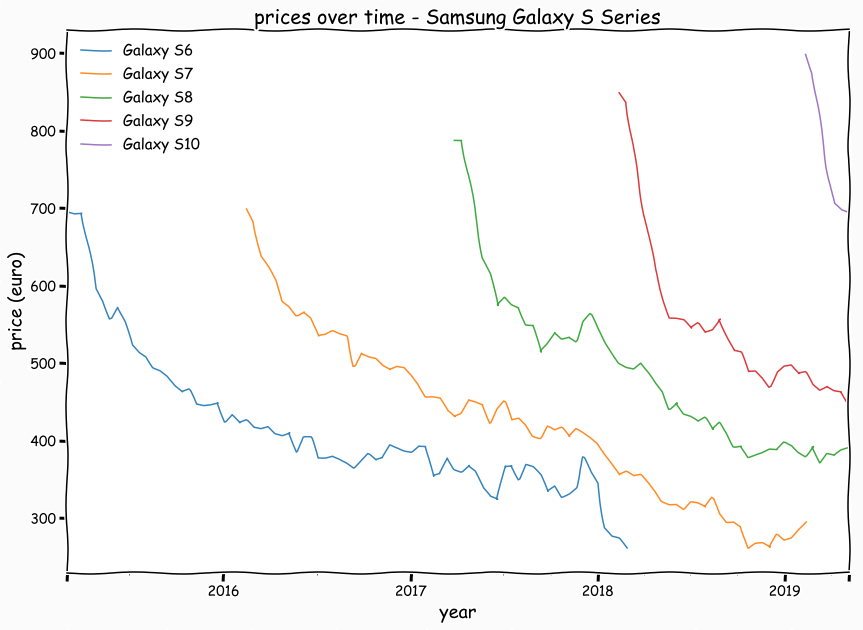

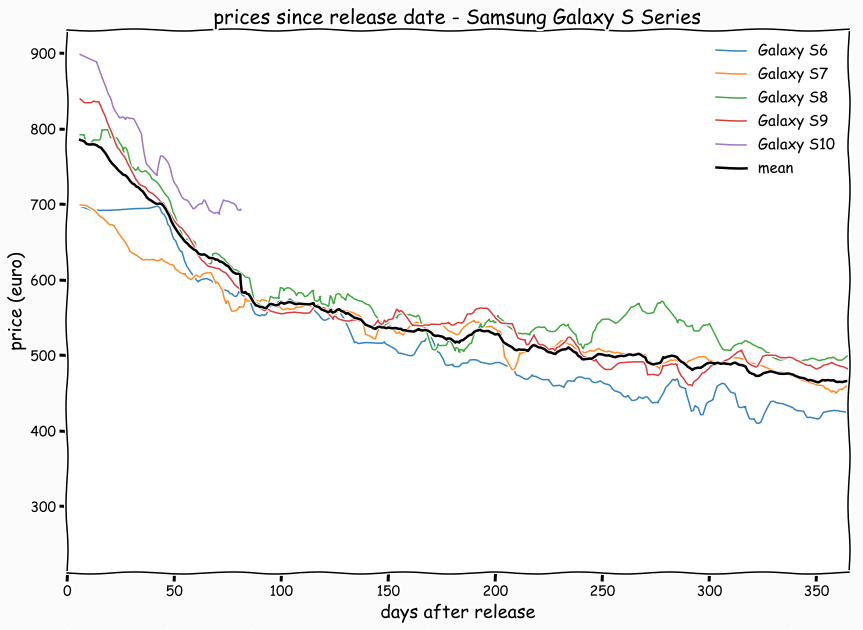

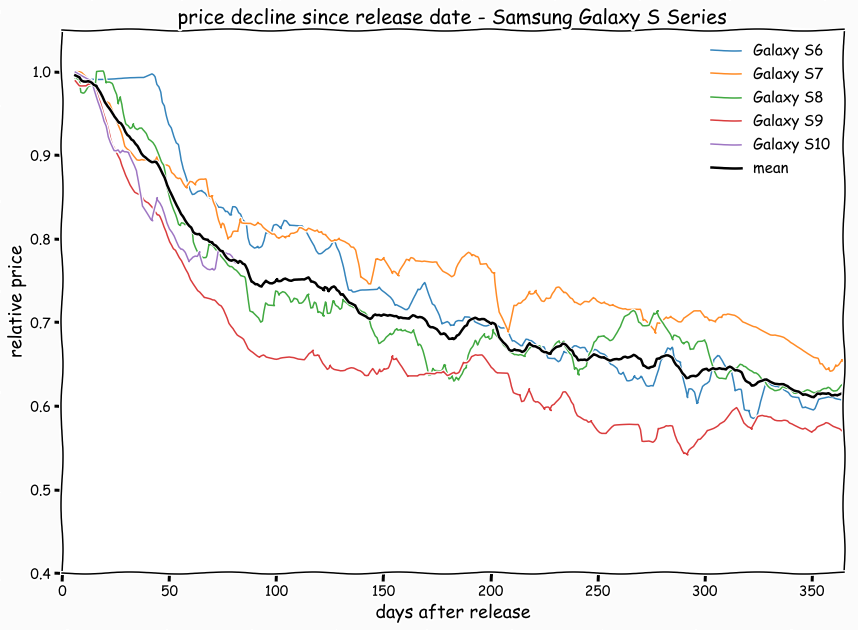

In [9]:
out_image_filetype = 'png'
manufacturer_list = df_analysis['manufacturer'].unique().tolist()

for manufacturer in manufacturer_list:

    df_manufacturer = df_analysis.loc[df_analysis['manufacturer'] == manufacturer]
    product_names = df_manufacturer['product'].unique().tolist()

    title = 'prices over time - '+ manufacturer
    df_figure = df_manufacturer.pivot_table(index='timestamp', columns='product', values='price').resample('14D').mean()
    ax = df_figure.plot(y=product_names, kind="line", figsize=(14, 10), linewidth=1.5, alpha=0.9)
    plt.title(title, fontsize=20)
    plt.xlabel('year', fontsize=18)
    plt.ylabel('price (euro)', fontsize=18)
    plt.legend(title=None, fontsize=15, frameon=False)
    fig = ax.get_figure()
    fig.patch.set_facecolor('#fbfbfb')
    outfile = '01_'+title+'.'+out_image_filetype
    fig.savefig(os.path.join('../figures', outfile), facecolor=fig.get_facecolor(), bbox_inches='tight')
    outfile_xlsx = title+'.xlsx'
    df_figure.to_excel(os.path.join('../data/final', outfile_xlsx))
    del ax, fig, df_figure

    title = 'prices since release date - '+ manufacturer
    df_figure = df_manufacturer.pivot_table(index='market_day', columns='product', values='price_avg_week')
    df_figure['mean'] = df_figure.mean(axis=1)
    ax = df_figure.plot(y=product_names, kind="line", figsize=(14, 10), xlim=(0, 365), linewidth=1.5, alpha=0.9)
    plt.plot(df_figure['mean'], color='black', linewidth=2.5)
    plt.title(title, fontsize=20)
    plt.xlabel('days after release', fontsize=18)
    plt.ylabel('price (euro)', fontsize=18)
    plt.legend(title=None, fontsize=15, frameon=False)
    fig = ax.get_figure()
    fig.patch.set_facecolor('#fbfbfb')
    outfile = '02_'+title+'.'+out_image_filetype
    fig.savefig(os.path.join('../figures', outfile), facecolor=fig.get_facecolor(), bbox_inches='tight')
    outfile_xlsx = title+'.xlsx'
    df_figure.to_excel(os.path.join('../data/final', outfile_xlsx))    
    del ax, fig, df_figure

    title = 'price decline since release date - '+ manufacturer
    df_figure = df_manufacturer.pivot_table(index='market_day', columns='product', values='price_perc_week')
    df_figure['mean'] = df_figure.mean(axis=1)
    ax = df_figure.plot(y=product_names, kind="line", figsize=(14, 10), xlim=(0, 365), ylim=(0.4, 1.05), linewidth=1.5, alpha=0.9)
    plt.plot(df_figure['mean'], color='black', linewidth=2.5)
    plt.title(title, fontsize=20)
    plt.xlabel('days after release', fontsize=18)
    plt.ylabel('relative price', fontsize=18)
    plt.legend(title=None, fontsize=15, frameon=False)
    fig = ax.get_figure()
    fig.patch.set_facecolor('#fbfbfb')
    outfile = '03_'+title+'.'+out_image_filetype
    fig.savefig(os.path.join('../figures', outfile), facecolor=fig.get_facecolor(), bbox_inches='tight')
    outfile_xlsx = title+'.xlsx'
    df_figure.to_excel(os.path.join('../data/final', outfile_xlsx))
    del ax, fig, df_figure